In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
%matplotlib inline

In [2]:
def tryfun(f):
    def wrapper(i):
        try:
            return f(i)
        except:
            return np.NaN
    return wrapper

# Outputs


In [3]:
notifs = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Notificaciones TB/GTM - TB all notifications 2012-Sep2018.csv")

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (7,8,9,11,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,72,74,78,79,80,81,83,84,85,87,89,90,91,93,94,98,102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [110]:
notifs.loc[notifs.COD_MUNI == 1422, "COD_MUNI"] = 1420

In [4]:
notifs["Year"] = np.floor(notifs.YearMonth/100)

In [111]:
casesNotif = notifs[(notifs.Year<2018) & notifs.COD_MUNI.notna()].assign(municipality = lambda x: x.COD_MUNI).assign(date=lambda x: x.Year.astype(int))\
.assign(department = lambda x: (np.floor(x.COD_MUNI/100)).astype(int) ).groupby(["date", "department", "municipality"]).apply(len)

In [112]:
casesNotif = casesNotif[casesNotif.index.get_level_values(1)!=0].rename("Cases Notified_value_m").fillna(0)

In [7]:
extraM2017 = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Extramuros2017.csv", index_col=0)

In [8]:
acfcases = extraM2017[extraM2017.Year.notna()].assign(municipality = lambda x: x.MuniCode.astype(int)).assign(date = lambda x: x.Year.astype(int)).\
assign(department = lambda x: x.DeptoCode.astype(int)).groupby(["date", "department", "municipality"])["bacteriologicos.extramuros"].sum()
acfcases = acfcases.rename("Additional Cases Detected via ACF_value_m").fillna(0)

In [9]:
#acfcases = acfcases.reindex(casesNotif.index)

In [10]:
# Cases Started on Treatment_value
# MDR Cases Started Treatment_value

cohortes = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/GTM - Tx cohort data 2012-2016.csv")

In [11]:
cohortes.head()

,Unnamed: 0,col_name,deptocode,row_name,row_name_B,table,value,year
0,0,I TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Genexpert,6.0,2016
1,1,II TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Genexpert,7.0,2016
2,2,III TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Genexpert,4.0,2016
3,3,IV TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Genexpert,8.0,2016
4,4,TOTAL,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Genexpert,25.0,2016


In [12]:
pivot_cohortes = cohortes[(cohortes.col_name.isin(["TOTAL"])) & 
       (cohortes.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", "Nuevos Pediatricos", 
                          "Nuevos Extrapulmonares", "Nuevos TB/VIH", "Retratamiento"])) &
       (cohortes.deptocode!=0)].\
    groupby(["year", "deptocode", "row_name_B"]).value.sum().unstack(2)

In [13]:
pivot_cohortes.head()

row_name_B      COMPLETED TREATMENT  DEATHS  LOST TO FOLLOW-UP  REFERRED
year deptocode                                                          
2012 1                        594.0    28.0               23.0       3.0
     2                         21.0     4.0                1.0       0.0
     3                         39.0     0.0                0.0       0.0
     4                         31.0     4.0                0.0       1.0
     5                        508.0    43.0               43.0       9.0

In [14]:
initiatedTx = pivot_cohortes.sum(axis=1)

In [15]:
initiatedTx = initiatedTx.rename_axis(index = { "year": "date", "deptocode": "department" }).rename("Cases Started on Treatment_value_d")

In [16]:
initiatedTx2 = initiatedTx.reindex(casesNotif.index).fillna(0)

In [17]:
# Reindex is not bad in this case??
initiatedTx.sum(), initiatedTx2.groupby([initiatedTx2.index.get_level_values(0), initiatedTx2.index.get_level_values(1)]).first().sum()

(17116.0, 17116.0)

In [18]:
tbquimio = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Notificaciones TB/GTM - TB quimio 2012-Sep2018.csv",
                     index_col = 0, low_memory = False)

In [19]:
tbquimio.head()

,NOMBRES,DIRECCION,MUNICIPIO,DEPARTAMENTO,SERVICIODESALUD,SEXO,EDAD,RANGOEDAD,PESOLBS,PESOKG,...,CONTROL7_GX,OBSERVACIONES,PRIORIZACION,PESOLB,NotificationDate,YearMonth_,DEPTO_CORRECTED,i,COD_DEPT,COD_MUNI
1,NaN,NaN,GRANADOS,BAJA VERAPAZ,"CS, GRANADOS",f,1.0,000 - 004,13.4,6.0909090909090908,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,165,15,1505
2,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",f,8.0,005 - 009,50.8,23.090909090909086,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,167,15,1501
3,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",m,5.0,005 - 009,35,15.909090909090908,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,168,15,1501
4,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",m,6.0,005 - 009,36,16.363636363636363,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,169,15,1501
5,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",m,2.0,000 - 004,24.8,11.272727272727272,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,170,15,1501


In [20]:
tbquimio["Year"] = np.floor(tbquimio.YearMonth/100)

In [21]:
plhivipt= tbquimio[tbquimio.VIH=="Reactive"].assign(department = lambda x: np.floor(x.COD_MUNI/100))\
.groupby(["Year", "department", "COD_MUNI"]).apply(len)

In [22]:
plhivipt = plhivipt.rename("PLHIV started on IPT_value_m").fillna(0)\
.rename_axis(index={"Year": "date", "COD_MUNI": "municipality"}) #.reindex(casesNotif.index)

In [23]:
# This is only contacts in notifications database. I am not sure if its ok.

In [24]:
childipt= tbquimio[(tbquimio.Year<2018) & (tbquimio.EDAD <= 5)].assign(department = lambda x: np.floor(x.COD_MUNI/100))\
.groupby(["Year", "department", "COD_MUNI"]).apply(len).rename("Children in Contact with TB Started IPT_value_m")

In [25]:
childipt = childipt.rename_axis(index={"Year": "date", "COD_MUNI": "municipality"}) #.reindex(casesNotif.index)

In [26]:
# Cases Notified in Prisons_value
pplcases = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Prisoners/PPL-conteos-2014-2017.csv", index_col=0)

In [27]:
pplcases = pplcases.assign(department = lambda x : np.floor(x.municipio/100)).rename(columns=\
{"n": "Cases Notified in Prisons_value", "YEAR": "date", "municipio": "municipality"}).set_index(["date", "department", "municipality"])

In [28]:
pplcases = pplcases.reindex(casesNotif.index)

In [29]:
ppldata = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Prisoners/tb-ppl-2014-2017.csv")

In [30]:
ppldata["TXDATE"] = pd.to_datetime(ppldata.TXDATE, errors="coerce")

In [31]:
# Sólo una persona no recibió tratamiento.
ppldata.TXDATE.isna().sum()

1

In [32]:
ppltx = ppldata[ppldata.TXDATE.notna()].assign(department = lambda x: np.floor(x.municode/100).astype(int) )\
.assign(date = lambda x: x.TXDATE.map(lambda y: y.year ))\
.groupby(["date", "department" , "municode"]).apply(len)\
.rename_axis(index={"municode": "municipality"})\
.rename("Cases Started on Treatment in Prisons_value_m")

In [33]:
ppltx = ppltx[ppltx.index.get_level_values("date")>2012]
ppltx

date  department  municipality
2014  1           101             17
                  113              5
      5           501             44
      6           601              1
      9           901              4
      18          1801            13
      19          1901             4
2015  1           101             19
                  113              7
      5           501             49
      9           901              5
      10          1001             1
      18          1801            30
2016  1           101             39
                  113             12
      5           501             54
      9           901             11
      10          1001             1
      17          1701             1
      18          1801            37
      19          1901             1
2017  1           101             41
                  113             26
      5           501             57
      6           601              4
      9           901              6
      1

In [34]:
# Lets see in the cohort data:
hivyear_A = cohortes[(cohortes.col_name.isin(["TOTAL"])) & 
       (cohortes.table.isin(["Nuevos TB/VIH"])) &
       (cohortes.deptocode==0)].groupby("year").value.sum()
hivyear_A

year
2012    269.0
2013    226.0
2014    197.0
2015    173.0
2016    163.0
Name: value, dtype: float64

In [35]:
# Now with notifications data:
hivyear_B = notifs.groupby(["YEAR", "VIH"]).apply(len).unstack(1)["Reactive"]
hivyear_B

YEAR
2012    289.0
2013    277.0
2014    264.0
2015    201.0
2016    257.0
2017    243.0
2018    157.0
Name: Reactive, dtype: float64

In [36]:
# HIV counts per year, from cohort and from notifications seems to be worse than in previous years
# This may be interpreted as the percentage of HIV cases that received treatment.
hivyear_A/hivyear_B

2012    0.930796
2013    0.815884
2014    0.746212
2015    0.860697
2016    0.634241
2017         NaN
2018         NaN
dtype: float64

In [37]:
# The actual data to integrate into the tables:
# HIV/TB Cases Notified_value

hivcases = notifs[(notifs.VIH == "Reactive") & (notifs.Year<2018) & notifs.COD_MUNI.notna()]\
.assign(municipality = lambda x: x.COD_MUNI.astype(int)).assign(date=lambda x: x.Year.astype(int))\
.assign(department = lambda x: (np.floor(x.COD_MUNI/100)).astype(int) ).groupby(["date", "department", "municipality"]).apply(len)\
.rename("HIV/TB Cases Notified_value_m")

In [38]:
# Now looking at MDR data in notifications:
notifs[notifs.DBCATEGORY=="MDR"].YEAR.value_counts()

2017    95
2018    28
Name: YEAR, dtype: int64

In [39]:
# There is actually a MDR table with all available cohort data:
mdrtb = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/GTM - TB MDR Cohort Data 2014-2016.csv")

In [40]:
mdrtb.head()

,Unnamed: 0,ID,X_0,Gender,Age,X_1,Muni,Depto,DAS,PxNew,...,TxDate_,TxDate_Year,DxDate_,DxDate_Year,ExitDate_,ExitDate_Year,PDSDate_,PDSDate_Year,GxDate_,deptocode
0,0,1.0,0.0,M,23.0,NaN,MEXICO,MEXICO,MEXICO,NaN,...,2014-01-30 00:00:00,2014.0,NaN,NaN,2014-05-30 00:00:00,2014.0,2014-04-30 00:00:00,2014.0,NaN,NaN
1,1,2.0,60385.0,M,48.0,NaN,Mazatenango,Suchitepequez,Suchitepequez,NaN,...,2014-02-10 00:00:00,2014.0,NaN,NaN,2014-06-17 00:00:00,2014.0,2013-06-05 00:00:00,2013.0,NaN,10.0
2,2,3.0,57633.0,M,19.0,NaN,Guatemala,Guatemala,Guatemala Central,NaN,...,10/02/2014 Y 26/06/14,NaN,NaN,NaN,2014-02-25 00:00:00,2014.0,NaN,NaN,NaN,1.0
3,3,4.0,60414.0,M,22.0,NaN,Retalhuleu,Retalhuleu,Retalhuleu,NaN,...,2014-02-10 00:00:00,2014.0,NaN,NaN,2014-06-17 00:00:00,2014.0,2013-10-29 00:00:00,2013.0,NaN,11.0
4,4,5.0,56470.0,M,79.0,NaN,Mazatenango,Suchitepequez,Suchitepequez,NaN,...,2014-02-10 00:00:00,2014.0,NaN,NaN,2014-06-17 00:00:00,2014.0,2013-06-11 00:00:00,2013.0,NaN,10.0


In [41]:
mdrtb.Year.value_counts()

16    76
14    41
15    40
Name: Year, dtype: int64

In [42]:
# How many bad tx initiation date values are there?
mdrtb.groupby("Year").apply(lambda x: x.TxDate_Year.isna().sum())

Year
14     1
15     6
16    22
dtype: int64

In [43]:
# MDR Cases Notified_value
# MDR Cases Started Treatment_value

mdrcases = mdrtb[mdrtb.deptocode.notna()].assign(date = lambda x: x.Year+2000).assign(department = lambda x: x.deptocode.astype(int))\
    .groupby(["date","department"]).apply(len).rename("MDR Cases Notified_value_d")
    
mdrtx = mdrtb[mdrtb.deptocode.notna()].assign(date = lambda x: x.TxDate_Year.map(tryfun(int)) ).assign(department = lambda x: x.deptocode.astype(int))\
    .groupby(["date","department"]).apply(len).rename("MDR Cases Started Treatment_value_d")

mdrtx = mdrtx[mdrtx.index.get_level_values(0)>2012]

In [113]:
outputs = pd.merge(casesNotif, acfcases, left_index=True, right_index=True, how="outer")\
            .merge(initiatedTx, left_index=True, right_index=True, how="outer")\
            .merge(plhivipt, left_index=True, right_index=True, how="outer")\
            .merge(childipt, left_index=True, right_index=True, how="outer")\
            .merge(pplcases, left_index=True, right_index=True, how="outer")\
            .merge(ppltx, left_index=True, right_index=True, how="outer")\
            .merge(hivcases, left_index=True, right_index=True, how="outer")\
            .merge(mdrcases, left_index=True, right_index=True, how="outer")\
            .merge(mdrtx, left_index=True, right_index=True, how="outer")\

In [114]:
outputs.head()

Cases Notified_value_m  \
date   department municipality                           
2012.0 1.0        101.0                          318.0   
                  102.0                            5.0   
                  103.0                           15.0   
                  104.0                            1.0   
                  105.0                            4.0   

                                Additional Cases Detected via ACF_value_m  \
date   department municipality                                              
2012.0 1.0        101.0                                               NaN   
                  102.0                                               NaN   
                  103.0                                               NaN   
                  104.0                                               NaN   
                  105.0                                               NaN   

                                Cases Started on Treatment_value_d  \
date   department municipality                                       
2012.0 1.0        101.0                                      648.0   
                  102.0                                      648.0   
                  103.0                                      648.0   
                  104.0                                      648.0   
                  105.0                                      648.0   

                                PLHIV started on IPT_value_m  \
date   department municipality                                 
2012.0 1.0        101.0                                  2.0   
                  102.0                                  NaN   
                  103.0                                  NaN   
                  104.0                                  NaN   
                  105.0                                  NaN   

                                Children in Contact with TB Started IPT_value_m  \
date   department municipality                                                    
2012.0 1.0        101.0                                                    40.0   
                  102.0                                                     1.0   
                  103.0                                                     1.0   
                  104.0                                                     NaN   
                  105.0                                                     NaN   

                                Cases Notified in Prisons_value  \
date   department municipality                                    
2012.0 1.0        101.0                                     NaN   
                  102.0                                     NaN   
                  103.0                                     NaN   
                  104.0                                     NaN   
                  105.0                                     NaN   

                                Cases Started on Treatment in Prisons_value_m  \
date   department municipality                                                  
2012.0 1.0        101.0                                                   NaN   
                  102.0                                                   NaN   
                  103.0                                                   NaN   
                  104.0                                                   NaN   
                  105.0                                                   NaN   

                                HIV/TB Cases Notified_value_m  \
date   department municipality                                  
2012.0 1.0        101.0                                  31.0   
                  102.0                                   NaN   
                  103.0                                   3.0   
                  104.0                                   1.0   
                  105.0                                   NaN   

                                MDR Cases Notified_value_d  \
date   

In [115]:
outputs.to_csv("outputs.csv")

# Activities

Not available: 
* Tests Conducted_value
* Active Case Finding Missions Conducted_value
* Prisoners Screened_value


In [47]:
# Tests Conducted_value
sicoinRM = pd.read_csv("../../../Resource Tracking/SICOIN GT/IGRC02_PCE_Ejecucion_Fisica.csv")

In [48]:
sicoinTB = sicoinRM[(sicoinRM.Programa == "17-PREVENCIÓN Y CONTROL DE LA TUBERCULOSIS") ]

In [51]:
distrMeds = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Distribución Medicamentos TB/GTM-TB-distribution-2013-2018.csv", index_col=0)

In [52]:
distrMeds.head()

,Program,Product,Supplier,Department,Year,Month,Amount,Recipient,MG,Medicine,ML,code_dept
0,PROGRAMA NACIONAL DE TUBERCULOSIS,"ISONIAZIDA, TABLETA DE 300 MG.","RESCO, SOCIEDAD ANONIMA/ OPS",ALTA VERAPAZ,2013,1,0.0,DAS,300,ISONIAZIDA,0.0,16
1,PROGRAMA NACIONAL DE TUBERCULOSIS,"ISONIAZIDA, TABLETA DE 300 MG.","RESCO, SOCIEDAD ANONIMA/ OPS",ALTA VERAPAZ,2013,2,2740.0,DAS,300,ISONIAZIDA,0.0,16
2,PROGRAMA NACIONAL DE TUBERCULOSIS,"ISONIAZIDA, TABLETA DE 300 MG.","RESCO, SOCIEDAD ANONIMA/ OPS",ALTA VERAPAZ,2013,3,0.0,DAS,300,ISONIAZIDA,0.0,16
3,PROGRAMA NACIONAL DE TUBERCULOSIS,"ISONIAZIDA, TABLETA DE 300 MG.","RESCO, SOCIEDAD ANONIMA/ OPS",ALTA VERAPAZ,2013,4,0.0,DAS,300,ISONIAZIDA,0.0,16
4,PROGRAMA NACIONAL DE TUBERCULOSIS,"ISONIAZIDA, TABLETA DE 300 MG.","RESCO, SOCIEDAD ANONIMA/ OPS",ALTA VERAPAZ,2013,5,3376.0,DAS,300,ISONIAZIDA,0.0,16


In [53]:
meds = distrMeds.groupby(["Year", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "date", "code_dept": "department"})\
.rename("Total Drugs Distributed_value_d")

In [54]:
distrMeds.Medicine.unique()

array(['ISONIAZIDA', 'RIFAMPICINA', 'PIRAZINAMIDA', 'ETAMBUTOL',
       'ESTREPTOMICINA', 'KANAMICINA', 'CICLOCERINA', 'ETHIONAMIDA',
       'LEVOFLOXACINA', 'TUBERCULINA', 'CLOFAZIMINE',
       'AMOXICILINA/ACIDO CLAVULANICO', 'MOXIFLOXACINA', 'CICLOSERINA',
       'CAPREOMICINA', 'ACIDO PARAAMINOSALICILICO', 'LINEZOLID',
       'IMIPENEM/CILASTATINA'], dtype=object)

In [55]:
# Isoniazid Distributed_value
isod = distrMeds[distrMeds.Medicine == "ISONIAZIDA"].groupby(["Year", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "date", "code_dept": "department"})\
.rename("Isoniazid Distributed_value_d")

In [56]:
# PLHIV Screened for TB_value
hivtb = \
sicoinRM[(sicoinRM.Programa == "16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA") &
sicoinRM.Resultado.isin(
       ['6.0-Paciente VIH positivo, con prueba diagnóstica de tuberculosis',
       '6.0-Pacientes VIH positivos, con prueba diagnostica de Tuberculosis']
) & (sicoinRM.LugarEjecutado.notna())].assign(date = lambda x: x.Year, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["date", "municipality"]).LugarEjecutado.sum()\
.rename("PLHIV Screened for TB_value_m")

In [57]:
# TB Patients Tested for HIV_value
tbhivTx = sicoinRM[(sicoinRM.Programa == "17-PREVENCIÓN Y CONTROL DE LA TUBERCULOSIS") &
sicoinRM.Resultado.isin(
       ['7.0-Persona con diagnóstico de tuberculosis con prueba diagnóstica de VIH',
       '7.0-Casos de Tuberculosis con prueba diagnóstica de VIH']
) & (sicoinRM.LugarEjecutado.notna())].assign(date = lambda x: x.Year, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["date", "municipality"]).LugarEjecutado.sum()\
.rename("TB Patients Tested for HIV_value_m")

In [58]:
# Number of Cases Screened for MDR_value
mdrSx = sicoinRM[(sicoinRM.Programa == "17-PREVENCIÓN Y CONTROL DE LA TUBERCULOSIS") &
sicoinRM.Resultado.isin(
       ['9.0-Persona con diagnóstico de fracasos al tratamiento de tuberculosis con prueba diagnóstica a TB-MDR (tuberculosis multidrogo resistente)',
        '9.0-Casos de fracasos a tratamiento de Tuberculosis con prueba diagnóstica a TB-MDR']
) & (sicoinRM.LugarEjecutado.notna())].assign(date = lambda x: x.Year, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["date", "municipality"]).LugarEjecutado.sum()\
.rename("Number of Cases Screened for MDR_value_m")

In [59]:
cohortsExtraD = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/GTM - Tx Cohort Data - Extra tables.csv")

In [60]:
cohortsExtraD.columns

Index(['year', 'table', 'das', 'column', 'value', 'col_index', 'deptocode'], dtype='object')

In [61]:
cohortsExtraD.table.unique()

array(['SR', 'Nuevos BK+', 'Nuevos BK-', 'Nuevos Extrapulmonares',
       'Pediatricos', 'TB/VIH Iniciaron TARV', 'TB/VIH Tx Preventivo',
       'SR Extension Cobertura', 'Nuevos BK+ Extension Cobertura',
       'Tamizaje Contactos', 'Contactos con TB', 'Contactos Tx 0-10a',
       'Centros de salud EATB', 'Puestos de salud EATB',
       'Hospitales EATB', 'Jurisdicciones EATB', 'Otros EATB',
       'Laboratorios', 'Laboratorios baciloscopias',
       'Laboratorios cultivo', 'Laboratorios sensibilidad drogas',
       'Contactos Tx 0-5a', 'VIH Tx Preventivo', 'ExtCob EATB'],
      dtype=object)

In [62]:
cohortes.table.unique()

array(['Nuevos Pulmonares Genexpert', 'Nuevos Pulmonares pediatricos BK+',
       'Nuevos Pulmonares pediatricos BK-', 'Nuevos Extrapulmonares BK+',
       'Nuevos Extrapulmonares pediatricos BK+',
       'Nuevos Extrapulmonares BK-',
       'Nuevos Extrapulmonares pediatricos BK-',
       'Nuevos Pulmonares TB/VIH BK+', 'Retratamiento BK+',
       'Retratamiento Recaidas & BK+',
       'Retratamiento Abandonos Recuperados & BK+',
       'Retratamiento Fracasos & BK+', 'Retratamiento TB/VIH & BK+',
       'Retratamiento BK-', 'Retratamiento Recaidas & BK-',
       'Retratamiento Abandonos Recuperados & BK-',
       'Retratamiento Fracasos & BK-', 'Retratamiento TB/VIH & BK-',
       'Retratamiento Extrapulmonar',
       'Retratamiento Extrapulmonar & TB/VIH',
       'MDR sensitivity tests on new', 'MDR confirmed cases from new',
       'MDR test on previously treated',
       'MDR confirmed from previously treated',
       'MDR 2nd line treatment begun', 'MDR TB/HIV',
       'MDR less 

In [63]:
cohortes[cohortes.table.isin(['MDR sensitivity tests on new','MDR test on previously treated']) & 
        (cohortes.deptocode==0)]

,Unnamed: 0,col_name,deptocode,row_name,row_name_B,table,value,year
648,648,NaN,0,NaN,NaN,MDR sensitivity tests on new,116.0,2016
650,650,NaN,0,NaN,NaN,MDR test on previously treated,65.0,2016
20442,20442,NaN,0,NaN,NaN,MDR sensitivity tests on new,210.0,2015
20444,20444,NaN,0,NaN,NaN,MDR test on previously treated,94.0,2015
38298,38298,NaN,0,NaN,NaN,MDR sensitivity tests on new,22.0,2014
38300,38300,NaN,0,NaN,NaN,MDR test on previously treated,0.0,2014
61434,61434,NaN,0,NaN,NaN,MDR sensitivity tests on new,67.0,2013
61436,61436,NaN,0,NaN,NaN,MDR test on previously treated,72.0,2013
81264,81264,NaN,0,NaN,NaN,MDR sensitivity tests on new,62.0,2012
81266,81266,NaN,0,NaN,NaN,MDR test on previously treated,67.0,2012


In [64]:
mdrSx = cohortes[cohortes.table.isin(['MDR sensitivity tests on new','MDR test on previously treated']) & 
        (cohortes.deptocode!=0)].groupby(["year", "deptocode"]).value.sum()\
            .rename_axis(index={ "year": "date", "deptocode": "department" })\
            .rename("Number of Cases Screened for MDR_value_d")

In [65]:
# Second Line Drugs Distributed_value

In [66]:
distrMeds.Medicine.unique()

array(['ISONIAZIDA', 'RIFAMPICINA', 'PIRAZINAMIDA', 'ETAMBUTOL',
       'ESTREPTOMICINA', 'KANAMICINA', 'CICLOCERINA', 'ETHIONAMIDA',
       'LEVOFLOXACINA', 'TUBERCULINA', 'CLOFAZIMINE',
       'AMOXICILINA/ACIDO CLAVULANICO', 'MOXIFLOXACINA', 'CICLOSERINA',
       'CAPREOMICINA', 'ACIDO PARAAMINOSALICILICO', 'LINEZOLID',
       'IMIPENEM/CILASTATINA'], dtype=object)

In [67]:
# De acuerdo al manual de tb drogoresistente del programa
segundaLinea = [
    'LEVOFLOXACINA',
    'CAPREOMICINA',
    'MOXIFLOXACINA',
    'KANAMICINA',
    'ESTREPTOMICINA',
    'ETHIONAMIDA',
    'CICLOCERINA',
    'CICLOSERINA',
    'LINEZOLID',
    'CLOFAZIMINE',
    'PIRAZINAMIDA',
    'ETAMBUTOL',
    'ACIDO PARAAMINOSALICILICO',
    'IMIPENEM/CILASTATINA',
    'AMOXICILINA/ACIDO CLAVULANICO',
]

In [68]:
meds2dl = distrMeds[distrMeds.Medicine.isin(segundaLinea)].groupby(["Year", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "date", "code_dept": "department"})\
.rename("Total Drugs Distributed_value_d")

In [69]:
activities = pd.merge(meds, isod, left_index=True, right_index=True, how="outer")\
            .merge(hivtb, left_index=True, right_index=True, how="outer")\
            .merge(tbhivTx, left_index=True, right_index=True, how="outer")\
            .merge(mdrSx, left_index=True, right_index=True, how="outer")\
            .merge(meds2dl, left_index=True, right_index=True, how="outer")\
            

In [70]:
activities

Total Drugs Distributed_value_d_x  \
date department municipality                                      
2012 1.0        NaN                                         NaN   
     2.0        NaN                                         NaN   
     3.0        NaN                                         NaN   
     4.0        NaN                                         NaN   
     5.0        NaN                                         NaN   
     6.0        NaN                                         NaN   
     7.0        NaN                                         NaN   
     8.0        NaN                                         NaN   
     9.0        NaN                                         NaN   
     10.0       NaN                                         NaN   
     11.0       NaN                                         NaN   
     12.0       NaN                                         NaN   
     13.0       NaN                                         NaN   
     14.0       NaN                                         NaN   
     15.0       NaN                                         NaN   
     16.0       NaN                                         NaN   
     17.0       NaN                                         NaN   
     18.0       NaN                                         NaN   
     19.0       NaN                                         NaN   
     20.0       NaN                                         NaN   
     21.0       NaN                                         NaN   
     22.0       NaN                                         NaN   
2013 NaN        203.0                                       NaN   
                106.0                                       NaN   
                105.0                                       NaN   
                1015.0                                      NaN   
                205.0                                       NaN   
                603.0                                       NaN   
                108.0                                       NaN   
                608.0                                       NaN   
...                                                         ...   
2018 9.0        1212.0                                  50884.0   
                1213.0                                  50884.0   
                1215.0                                  50884.0   
                1217.0                                  50884.0   
                1218.0                                  50884.0   
                1222.0                                  50884.0   
                1226.0                                  50884.0   
                1401.0                                  50884.0   
                1501.0                                  50884.0   
                1502.0                                  50884.0   
                1503.0                                  50884.0   
                1504.0                                  50884.0   
                1505.0                                  50884.0   
                1507.0                                  50884.0   
                1508.0                                  50884.0   
                1701.0                                  50884.0   
                1702.0                                  50884.0   
                1705.0                                  50884.0   
                1706.0                                  50884.0   
                1710.0                                  50884.0   
                1711.0                                  50884.0   
                1712.0                                  50884.0   
                1713.0                                  50884.0   
                1805.0                                  50884.0   
                2003.0                                  50884.0   
                2004.0                                  50884.0   
                2006.0                                  50884.0   
          

In [73]:
activities.to_csv("activities.csv")

# Impact

In [72]:
# Worldpop estimations are in the helper functions 
import os

os.chdir("../../core/")
import GT_helper_functions as hf
import GT_load_data as data

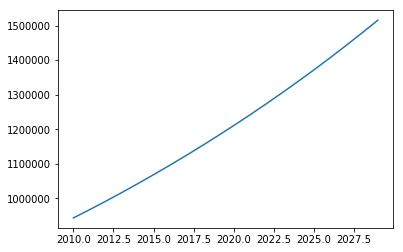

In [97]:
plt.plot(list(range(2010,2030) ), [ hf.GTMuniPopulation(101,y) for y in range(2010,2030)] )
None

In [122]:
notifsRate = casesNotif.reset_index().apply(lambda x: x["Cases Notified_value_m"] / hf.GTMuniPopulation(x.municipality, x.date), 1).iloc[:,0]

In [123]:
notifsRate.index = casesNotif.index.copy()

In [125]:
notifsRate = notifsRate.rename("Case Notification Rate_value")

In [128]:
# Mortality Rate_value
vrredis =  pd.read_csv("../../Outcome Measurement Data/MULTI/VR/vr_redistributed_collapsed_diseases.csv", index_col = 0)

In [131]:
munis_ids = pd.read_csv("../../Outcome Measurement Data/MULTI/VR/GTM_muni_merges_2009_2016.csv", index_col = 0)

In [133]:
vrredis = vrredis.merge(munis_ids[["adm2_country_code", "adm2_gbd_id"]], left_on= "location_id", right_on="adm2_gbd_id")

In [ ]:
vrredis

In [ ]:
vrredis[vrredis.disease.isin(["TB", "TB-VIH"])].groupby(["year_id", "location_id"]).deaths.sum()